# ***Can we predict , within 10 years, whether or not a person sees the risk to get coronary heart disease?***


## Summary:
 1. Initialization
 2. Show our dataset
 3. Data Exploration
 4. Modify and work on the dataset 
 5. Prediction with Logistic Regression
  - Confusion Matrix
  - Precision
  - Recall
  - F1-Score
  - Receiver Operating Characteristic (ROC) and Area Under the ROC Curve (AUC)
  - Accuracy
  

## Introduction
World Health Organization has estimated 12 million deaths occur worldwide, every year due to Heart diseases; in fact, Cardiovascular diseases are the number **1** cause of death globally!
The early predictions of cardiovascular diseases can make lifestyle changes in high risk patients, and it can reduce the complications.
This project intend to prove the correlation between current behaviours of a person, and his future risk of heart disease, using --models--

# 1. Initialization

In [ ]:
import argparse
from pathlib import Path
import pickle
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from termcolor import colored
from sklearn.model_selection import train_test_split
import sklearn.metrics as metric
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

At first, we:
 - load our dataset
 - delete rows with a NaN value inside 'heartRate','cigsPerDay','BMI','glucose','BPMeds','totChol'
 - substitute NaN values inside 'education' with 0

In [ ]:
df = pd.read_csv('datasets/framingham.csv', header='infer', encoding='utf-8')

In [ ]:
#delete rows with a NoNe value that is in 'heartRate','cigsPerDay','BMI','glucose','BPMeds','totChol'
columns_null=['heartRate', 'cigsPerDay', 'BMI', 'glucose', 'BPMeds', 'totChol']
for column in columns_null:
    df.drop(df[df[column].isna()==True].index, inplace=True)
    
    
#in 'education', substitute NaN values with 0
df['education'] = df['education'].fillna(0)

# 2. Show our dataset

The dataset consist of an ongoing cardiovascular study on residents of the town of Framingham, Massachusetts.

We have a dataset consisting of **3749 rows** and **16 columns**

In [ ]:
df.head(10)

### Description of the attributes

#### Demographic:
- Male:
 - 1 if male 
 - 0 if female


- Age: age of the patient in range (32,70)

#### Behavioral
- Education:
 - 0 if unknown
 - 1 = Some High School
 - 2 = High School or GED
 - 3 = Some College or Vocational School
 - 4 = college and further
 
 
- Current Smoker: 
  - 1 if the patient is a current smoker 
  - 0 if the patient is NOT a current smoker 
  

- Cigs Per Day: the number of cigarettes that the person smoked on average in one day

#### Medical (history)
- BP Meds: 
  - 1 if the patient is on blood pressure medication
  - 0 if the patient is NOT on blood pressure medication
  
  
- Prevalent Stroke: 
  - 1 if the patient had a stroke previously
  - 0 if the patient had NOT a stroke previously
  
  
- Prevalent Hyp:
  - 1 if the patient is hypertensive 
  - 0 if the patient is NOT hypertensive
  
  
- Diabetes: 
  - 1 if the patient has diabetes 
  - 0 if the patient has NOT diabetes 
  
  
#### Medical(current)
- Tot Chol: total cholesterol level


- Sys BP: systolic blood pressure 


- Dia BP: diastolic blood pressure


- BMI: Body Mass Index


- Heart Rate: heart rate


- Glucose: glucose level 


#### Predict variable (desired target)
- TenYearCHD: 10 year risk of coronary heart disease CHD
  - 1 if “Yes”
  - 0 if “No”

# 3. Data Exploration

Actually we can quite demonstrate that , for some of the variables, our dataset is enough balanced... but for other variables the dataset is NOT balanced


#### 1<sup>st</sup> example: SMOKERS vs NON-smokers

For example, we will notice that **current smokers** (and therefore also **current non-smokers**) cover almost half of the sample:

In [ ]:
countNoSmoker = len(df[df.currentSmoker == 0])
countSmoker = len(df[df.currentSmoker == 1])
print(colored("Percentage of Current NON-Smoker Patients: {:.2f}%".format((countNoSmoker / (len(df.currentSmoker)) *100)), 'green', attrs=['bold']))
print(colored("Percentage of Current Smoker Patients: {:.2f}%".format((countSmoker / (len(df.currentSmoker))*100)), 'green', attrs=['bold']))

#### 2<sup>nd</sup> example: patients WITH diabetes vs withOUT diabetes


*But sometime it doesn't happen!*

*For example, the percentage of patients with and without ***diabetes*** is not balanced:*

In [ ]:
diabetes0 = len(df[df.diabetes == 0])
diabetes1 = len(df[df.diabetes == 1])
print(colored("Percentage Patients WITH Diabetes: {:.2f}%".format((diabetes1 / (len(df.diabetes))*100)), 'green', attrs=['bold']))
print(colored("Percentage Patients withOUT Diabetes: {:.2f}%".format((diabetes0 / (len(df.diabetes))*100)), 'green', attrs=['bold']))



*In fact, as for the diabetes, we can note as well an imbalance about ***the prediction of the risk of coronary heart disease CHD within 10 years***:*



#### 3<sup>rd</sup> example: patients WITH or withOUT risk of coronary heart disease CHD within 10 years 

In [ ]:
target0 = len(df[df.TenYearCHD == 0])
target1 = len(df[df.TenYearCHD == 1])
print(colored("Percentage of Patients withOUT risk of coronary heart disease CHD within 10 years: {:.2f}%".format((target0 / (len(df.TenYearCHD))*100)),'green',attrs=['bold']))
print(colored("Percentage of Patients WITH risk of coronary heart disease CHD within 10 years: {:.2f}%".format((target1 / (len(df.TenYearCHD))*100)),'green',attrs=['bold']))

#### 4<sup>th</sup> example: frequency of a previous Stroke differentiated for Sex

Now let's see another example to show the balancing of the dataset, seeing the ***frequency of a previous Stroke differentiated for Sex***  

In [ ]:
pd.crosstab(df.male, df.prevalentStroke=='1').plot(kind="bar", figsize=(19.2, 10.8), color=['#AA1111'])
plt.title('Frequency of a previous Stroke for Sex', fontsize=20)
plt.xlabel('Sex:\n  0 = Female\n1 = Male')
plt.xticks(rotation=0)
plt.legend(["had a stroke previously"])
plt.ylabel('Frequency')
plt.show()

# 4. Modify and work on the dataset 

One of the choices we took to develop this project, is to divide our dataset into 2 parts:
  -  a **training** dataset ('train_set.csv'), that is the **80%** of our dataset
  - a **test** dataset ('test_set.csv'), that is the **20%** of our dataset

So at first we must normalize each value of those columns which values are in a too large range (we need that all the values are in the range **(0,1)**):

In [ ]:
columns_to_normalize=['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
for column in columns_to_normalize:
    df[column]=MinMaxScaler(copy=False).fit_transform(df[[column]])

In [ ]:
df.head(8)

Then, we create the ***training*** dataset and the ***test*** dataset using '***train_test_split***', a function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df[args.features], df[args.label], test_size=0.2)
pd.concat([x_train, y_train], axis=1, copy=False).to_csv(Path('datasets', 'train_set.csv'), index=False, encoding='utf-8')
pd.concat([x_test, y_test], axis=1, copy=False).to_csv(Path('datasets', 'test_set.csv'), index=False, encoding='utf-8')

#### TRAINING dataset

Our new TRAINING dataset will consist of **915 rows**

In [ ]:
df_train = pd.read_csv('datasets/train_set.csv', header='infer',encoding='utf-8')
df_train.head(7)

#### TEST dataset

Our new TEST dataset will consist of **229 rows**

In [ ]:
df_test = pd.read_csv('datasets/test_set.csv', header='infer',encoding='utf-8')
df_test.head(7)

# 5. Prediction with ***Logistic Regression***

One of the prediction models that we implemented is Logistic Regression (we are using "logistic_regression.pkl", a file inside "models" folder of our repository)

In [9]:
path=Path('C:/Users/Flavia/Documents/GitHub/FDS-Final/models/logistic_regression.pkl')
with open(path,'rb') as file:
    model=pickle.load(file)

We want the **X_test** as our test-dataset with all the features, without the target column 'TenYearCHD': 

In [12]:
X_test=df_test.copy(deep=True)
X_test.drop('TenYearCHD',axis=1,inplace=True)

so our target column will be:

In [13]:
target=df_test['TenYearCHD']

### 1. Confusion Matrix

Let's calculate the **predicted output**, using the predict() function:

In [14]:
predictions=model.predict(X_test)

In [15]:
predictions

array([1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1], dtype=int64)

and calculate the Confusion Matrix:

In [16]:
cm = confusion_matrix(np.array(df_test['TenYearCHD']), predictions)

and see the results:

<Figure size 432x288 with 0 Axes>

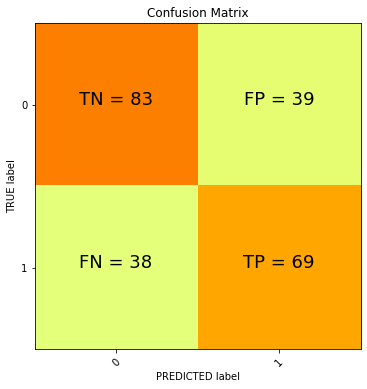

In [17]:
plt.clf()
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title('Confusion Matrix')
plt.ylabel('TRUE label')
plt.xlabel('PREDICTED label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha='center',fontsize=18)
plt.show()

This plot helps us to find the True Positives, True Negatives, False Positives an False Negatives of the prediction; in fact we can visualize:
 - rows as the **true** labels
 - coumns as the **predict** labels

So we obtained:
 - 69 **true** Positive predictions (that is, the prediction says that a patient RUNS the risk, and he **really** runs the risk!)
 - 83 **true** Negative predictions (that is, the prediction says that a patient DOESN'T run the risk, and he **really** DOESN'T run the risk!)
 - 39 **false** Positive predictions (that is, the prediction says that a patient RUNS the risk, but he **doesn't** really run the risk!)
 - 38 **false** Negative predictions (that is, the prediction says that a patient DOESN'T run the risk, but he **really** run the risk!)

### 2. Precision

Let's calculate the precision:

In [18]:
precision=metric.precision_score(target,predictions)

In [19]:
print('The percentage of the accuracy of our positive predictions, represented by the Precision, is: ',"{:.2%}".format(precision))

The percentage of the accuracy of our positive predictions, represented by the Precision, is:  63.89%


### 3. Recall

In [20]:
recall=metric.recall_score(target,predictions)

In [21]:
print('The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is: ',"{:.2%}".format(recall))

The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is:  64.49%


### 4. F1-score

In [150]:
f1_score=metric.f1_score(target,predictions)

In [151]:
print('The F1-Score, is: ',"{:.2%}".format(f1_score))

The F1-Score, is:  64.19%


It represents the **harmonic** mean of precision and recall.
Instead of the regular mean (that gives equal weight to all values), harmonic mean gives more weight to low values, 
favoring classifiers that have similar precision and recall.

### 5. Receiver Operating Characteristic (ROC) and Area Under the ROC Curve (AUC)

Now let's calculate the **predicted probabilities of getting the output as 1**, using the predict.proba() function:

In [23]:
predictions=model.predict_proba(X_test)[:,1]

calculate ROC and AUC:

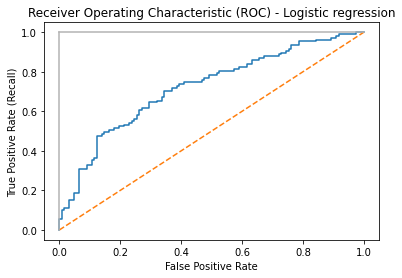

 The Area Under the ROC curve (AUC) is:  0.7193963536080895


In [24]:
auc=roc_auc_score(np.array(df_test['TenYearCHD']), predictions)
false_positive_rate, true_positive_rate, threshold = roc_curve(np.array(df_test['TenYearCHD']), predictions)
plt.plot(figsize=(10,10))
plt.title('Receiver Operating Characteristic (ROC) - Logistic regression')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()
print(' The Area Under the ROC curve (AUC) is: ', auc)

Plotting the ROC curve, we are showing the ***true positive rate*** (recall) against the ***false positive rate*** (ratio of $0$ instances that are incorrectly classified as $1$, corresponding to $1 - specificity$ , where the specificity corresponds to the true negative rate, which is the ratio of $0$ instances that are correctly classified as $0$).

In this case, the ROC curve seems to suggest that the classifier is not so so bad... but we can extract more informations seeing the value of the AUC; 
in fact, we can accept AUC values that lie between 0.5 to 1, where 0.5 denotes a bad classifer and 1 denotes an excellent classifier.

Here, our Area Under the ROC Curve is equal to almost $0.72$ , so we can say **in general** that we obtained an acceptable discrimination... but **specifically** in contexts such as our case (medical diagnosis), very high (and higher than the result we obtained) AUCs are sought. 

### 6. Accuracy

So in the end, we can say that the overall predicted **accuracy** of the model is:

In [26]:
predictions=model.predict(X_test)

In [32]:
accuracy=accuracy_score(target,predictions)

In [36]:
print('The overall predicted accuracy of the model is: ',"{:.2%}".format(accuracy))

The overall predicted accuracy of the model is:  66.38%


# 6.  Prediction with ***K-Nearest Neighbors***

Another prediction models that we implemented is K-Nearest Neighbors model

In [31]:
path = Path('/Users/antoniozappia/Documents/GitHub/FDS-Final/models/KNN.pkl')
with open(path,'rb') as file:
    model=pickle.load(file)

To make our predictions on the KNN model we first load the TEST dataset and then we differentiate the feautres (The first fifteen columns) with the target (TenYearCHD column)

In [32]:
df_test = pd.read_csv("/Users/antoniozappia/Documents/GitHub/FDS-Final/datasets/test_set.csv")

In [33]:
X_test=df_test.copy(deep=True)
X_test.drop('TenYearCHD',axis=1,inplace=True)

In [34]:
target_test=df_test['TenYearCHD']

## Predictions

Like for Logistic Regression we start with the predictions output through the predict function

In [35]:
predictions=model.predict(X_test)

In [36]:
predictions

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0])

### 1. Confusion Matrix

In [37]:
cm = confusion_matrix(np.array(df_test['TenYearCHD']), predictions)

With this predictive model we get the following Confusion Matrix

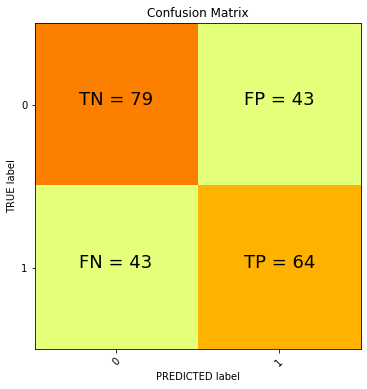

In [38]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title('Confusion Matrix')
plt.ylabel('TRUE label')
plt.xlabel('PREDICTED label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha='center',fontsize=18)
plt.show()

The plot rapresent the best view for the Confusion matrix. It's used for evaluating the performance of a classification model. This gives us a holistic view of how well our classification model is performing and what kinds of errors it is making. In this plot we can understand An equal value for the False Positive and False Negative, this will justify the equal values calculated for the Recall, Precision and F1-Score.

### 2. Precision

In [39]:
precision=metric.precision_score(target_test,predictions)

In [40]:
print('The percentage of the accuracy of our positive predictions, represented by the Precision, is: ',"{:.2%}".format(precision))

The percentage of the accuracy of our positive predictions, represented by the Precision, is:  59.81%


### 3. Recall 

In [41]:
recall=metric.recall_score(target_test,predictions)

In [42]:
print('The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is: ',"{:.2%}".format(recall))

The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is:  59.81%


### 4.F1-Score

In [43]:
f1_score=metric.f1_score(target_test,predictions)

In [44]:
print('The F1-Score, is: ',"{:.2%}".format(f1_score))

The F1-Score, is:  59.81%


After calculating the F1 Score as well, you can see how Precision, Recall and F1 Score have the same result. As previously mentioned, the values obtained in the Confusion Matrix (FN = FP) are fundamental to justify the values obtained for the Recall, Precision, F1- Score. Starting with Recall and Precision, I know by definition that:

Precision 𝑃 = $\frac{𝑇𝑃}{𝑇𝑃+𝐹𝑃}$

It represents the classifier’s ability to only predict really positive samples as positive. 

Recall 𝑅= $\frac{𝑇𝑃}{𝑇𝑃+𝐹𝑁}$

It represents the amount of positive test samples that were actually classified as positive.

Comparing the two operations we can see that the only element of difference concerns the type of False grip. In Precision the False Positive are considered while in the Recall the False Negatives. In our case FP and FN are the same for this reason Precision and Recall give equal values.

F1-Score is just the weighted average between precision and recall. But if Precision and recall are the same at the same time, F1-Score will also be the same


In [45]:
df_train = pd.read_csv("/Users/antoniozappia/Documents/GitHub/FDS-Final/datasets/train_set.csv")

In [46]:
X_train=df_train.copy(deep=True)
X_train.drop('TenYearCHD',axis=1,inplace=True)
target_train =df_train['TenYearCHD']

In [47]:
k_range = range(1, 21)

f1_score = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, target_train)
    y_pred = knn.predict(X_test)
    f1_score.append(metric.f1_score(target_test, y_pred))

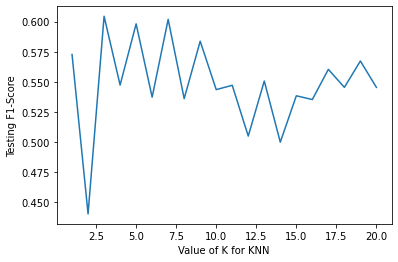

In [48]:
import matplotlib.pyplot as plt
plt.plot(k_range, f1_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing F1-Score')
plt.show()

Precisely on the F1-Score we concentrated trying to understand which neighbor value could bring an optimal F1-Score. We decided to vary the neighbor value in a range from 1 to 21 and for each value we applied our predictive model defining F1-Score. We then represented the F1-Score trend as K.

Analyzing the graph we can see how the best F1-Score is obtained for a reduced and limited K value between 3 and 7.

### 5. Accuracy 

In [49]:
accuracy=accuracy_score(target_test,predictions)

In [50]:
print('The overall predicted accuracy of the model is: ',"{:.2%}".format(accuracy))

The overall predicted accuracy of the model is:  62.45%


For each K from 1 to 20 we have obtained the accuracy value which we have subsequently inserted in a list and represented graphicallyOnce we calculated the accuracy score for k fixed equal to "", also in this case we decided to graphically represent the trend of the Accuracy Score as K varies.

In [51]:
k_range = range(1, 21)

accuracy_value = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, target_train)
    y_pred = knn.predict(X_test)
    accuracy_value.append(metric.accuracy_score(target_test, y_pred))

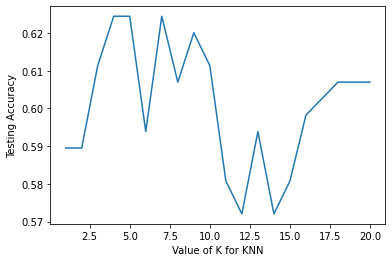

In [52]:
import matplotlib.pyplot as plt
plt.plot(k_range, accuracy_value)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
plt.show()

Also in this case the choice of the k value, to obtain the best Accuracy Score equal to about 0.62, falls into a low and limited range. Interval that we can consider equal

### 6. Receiver Operating Characteristic (ROC) and Area Under the ROC Curve (AUC)

In [53]:
predictions=model.predict_proba(X_test)[:,1]

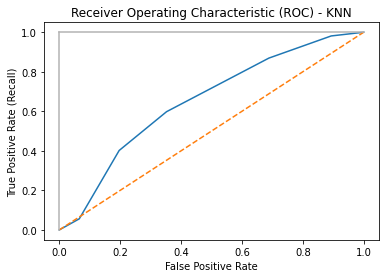

 The Area Under the ROC curve (AUC) is:  0.6514478320821204


In [54]:
auc=roc_auc_score(np.array(df_test['TenYearCHD']), predictions)
false_positive_rate, true_positive_rate, threshold = roc_curve(np.array(df_test['TenYearCHD']), predictions)
plt.plot(figsize=(10,10))
plt.title('Receiver Operating Characteristic (ROC) - KNN')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()
print(' The Area Under the ROC curve (AUC) is: ', auc)

The ROC Curve made for the KNN model compared to the other ROC curves is less fragmented and slightly linear. Also in this case the curve is located above the diagonal and this allows us to accept the model created. In this case the AUC value is equal to about 65%, lower than models like Neural Networks, therefore we have 65% chance that model will be able to distinguish between positive class and negative class. Analyzing the first part of the ROC Curve we realize how for very small values of TRUE Positive Rate and FALSE Positive Rate the ROC Curve concide

# 7. Predictions with ***Support Vector Machine (SVM)***

Another prediction models that we implemented is Support Vector Machine model

In [46]:
path = Path('/Users/antoniozappia/Documents/GitHub/FDS-Final/models/svm.pkl')
with open(path,'rb') as file:
    model=pickle.load(file)

To make our predictions on the KNN model we first load the TEST dataset and then we differentiate the feautres (The first fifteen columns) with the target (TenYearCHD column)

In [47]:
df_test = pd.read_csv("/Users/antoniozappia/Documents/GitHub/FDS-Final/datasets/test_set.csv")

In [48]:
X_test=df_test.copy(deep=True)
X_test.drop('TenYearCHD',axis=1,inplace=True)

In [49]:
target_test=df_test['TenYearCHD']

## Predictions

Like for Logistic Regression we start with the predictions output through the predict function

In [50]:
predictions=model.predict(X_test)

In [51]:
predictions

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1])

### 1.Confusion Matrix

In [52]:
cm = confusion_matrix(np.array(df_test['TenYearCHD']), predictions)

In [53]:
cm

array([[81, 41],
       [37, 70]])

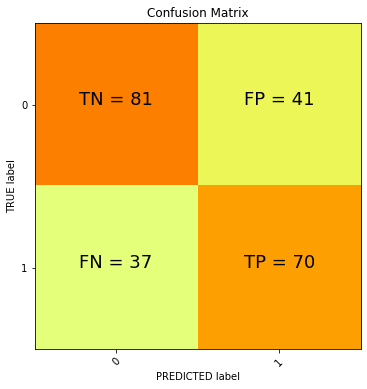

In [54]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title('Confusion Matrix')
plt.ylabel('TRUE label')
plt.xlabel('PREDICTED label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha='center',fontsize=18)
plt.show()

We also represented the Confusion Matrix for the SVM (Supported vector machine) model. We can note also in this case, as for the Neural Network, the False Positive and False Negative are not the same this will lead to different values in the definition of Precision and Recall. Compared to the previous models, the SVM model is more accurate having a higher value than TRUE (Negative and Positive) and at the same time lower False Positive and False Negative

### 2. Precision value

In [55]:
precision=metric.precision_score(target_test,predictions)

In [56]:
print('The percentage of the accuracy of our positive predictions, represented by the Precision, is: ',"{:.2%}".format(precision))

The percentage of the accuracy of our positive predictions, represented by the Precision, is:  63.06%


As a direct consequence of the Confusion Matrix analysis we find higher precision and recall values than models like KNN, Neural Networks. This is because both False Positive (for Precison) and False Negative (for Recall) are lower.

### 3. Recall value

In [57]:
recall=metric.recall_score(target_test,predictions)

In [58]:
print('The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is: ',"{:.2%}".format(recall))

The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is:  65.42%


### 4. F1-Score

In [59]:
f1_score=metric.f1_score(target_test,predictions)

In [60]:
print('The F1-Score, is: ',"{:.2%}".format(f1_score))

The F1-Score, is:  64.22%


### 5. Accuracy 

In [61]:
accuracy=accuracy_score(target_test,predictions)

In [62]:
print('The overall predicted accuracy of the model is: ',"{:.2%}".format(accuracy))

The overall predicted accuracy of the model is:  65.94%


### 6. Receiver Operating Characteristic (ROC) and Area Under the ROC Curve (AUC)

In [63]:
predictions=model.predict_proba(X_test)[:,1]

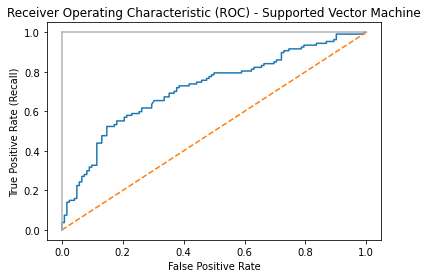

 The Area Under the ROC curve (AUC) is:  0.7164853684694347


In [65]:
auc=roc_auc_score(np.array(df_test['TenYearCHD']), predictions)
false_positive_rate, true_positive_rate, threshold = roc_curve(np.array(df_test['TenYearCHD']), predictions)
plt.plot(figsize=(10,10))
plt.title('Receiver Operating Characteristic (ROC) - Supported Vector Machine')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()
print(' The Area Under the ROC curve (AUC) is: ', auc)

The ROC Curve made for the SVM model has a very positive trend in fact it is considerably above the diagonal. Comparing the AUC values with respect to the various models proposed by us, the SVM model presents one of the highest values, about 72% chance that model will be able to distinguish between positive class and negative class.

# 8.  Prediction with ***Neural Networks***

Another prediction models that we implemented is Neural Networks model

In [27]:
path = Path('/Users/antoniozappia/Documents/GitHub/FDS-Final/models/neural_networks.pkl')
with open(path,'rb') as file:
    model=pickle.load(file)

To make our predictions on the KNN model we first load the TEST dataset and then we differentiate the feautres (The first fifteen columns) with the target (TenYearCHD column)

In [28]:
df_test = pd.read_csv("/Users/antoniozappia/Documents/GitHub/FDS-Final/datasets/test_set.csv")

In [29]:
X_test=df_test.copy(deep=True)
X_test.drop('TenYearCHD',axis=1,inplace=True)

In [30]:
target_test=df_test['TenYearCHD']

## Predictions

Like for Logistic Regression we start with the predictions output through the predict function

In [31]:
predictions=model.predict(X_test)

In [32]:
predictions

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0])

### 1. Confusion Matrix

In [33]:
cm = confusion_matrix(np.array(df_test['TenYearCHD']), predictions)

In [34]:
cm

array([[69, 53],
       [42, 65]])

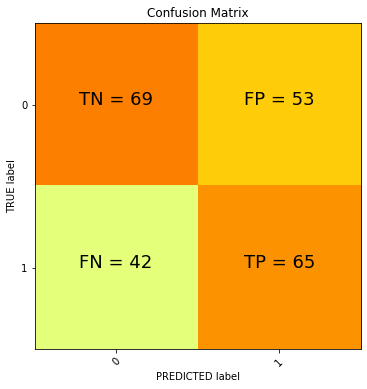

In [35]:
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['0','1']
plt.title('Confusion Matrix')
plt.ylabel('TRUE label')
plt.xlabel('PREDICTED label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]),ha='center',fontsize=18)
plt.show()

Analyzing the confusion matrix for the Neural Network model we cannot see how in the KNN an equal value for FP and FN. There is a variation that will lead to different values for precision, recall and F1-Score. Continuing the comparison with the KNN model we can see almost equal values for True Positive, True Negative.

### 2. Precision value

In [36]:
precision=metric.precision_score(target_test,predictions)

In [37]:
print('The percentage of the accuracy of our positive predictions, represented by the Precision, is: ',"{:.2%}".format(precision))

The percentage of the accuracy of our positive predictions, represented by the Precision, is:  55.08%


The Precision value is lower than the Recall value and this is completely justified by the FP and FN values. In the precision we find the denominator FP which being higher than the FN give a smaller value than the Recall where we use the FN.

### 3. Recall value

In [38]:
recall=metric.recall_score(target_test,predictions)

In [39]:
print('The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is: ',"{:.2%}".format(recall))

The ratio of positive instances that are correctly detected by the classifier (true positive rate), represented by the Recall, is:  60.75%


### 4. F1-Score

In [40]:
f1_score=metric.f1_score(target_test,predictions)

In [41]:
print('The F1-Score, is: ',"{:.2%}".format(f1_score))

The F1-Score, is:  57.78%


The F1-Score represents the weighted average between Precision and Recall

### 5. Accuracy 

In [42]:
accuracy=accuracy_score(target_test,predictions)

In [43]:
print('The overall predicted accuracy of the model is: ',"{:.2%}".format(accuracy))

The overall predicted accuracy of the model is:  58.52%


### 6. Receiver Operating Characteristic (ROC) and Area Under the ROC Curve (AUC)

In [44]:
predictions=model.predict_proba(X_test)[:,1]

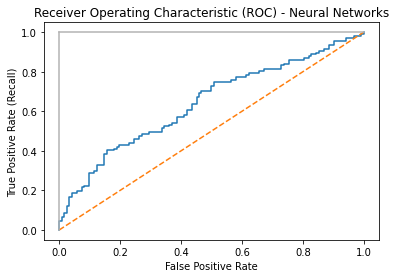

 The Area Under the ROC curve (AUC) is:  0.6407997548644093


In [45]:
auc=roc_auc_score(np.array(df_test['TenYearCHD']), predictions)
false_positive_rate, true_positive_rate, threshold = roc_curve(np.array(df_test['TenYearCHD']), predictions)
plt.plot(figsize=(10,10))
plt.title('Receiver Operating Characteristic (ROC) - Neural Networks')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate (Recall)')
plt.xlabel('False Positive Rate')
plt.show()
print(' The Area Under the ROC curve (AUC) is: ', auc)


The ROC Curve created for the Neural Networks model reports the trend of the True Positive Rate (Recall) with respect to the FP Rate. The resulting curve tells us how much model is capable of distinguishing between classes. The curve is located above the diagonal and this allows us to state that the model made is not bad. To give a more detailed explanation, let's analyze the AUC value which represents the area under the curve. For the Neural Networks model it is equal to about 0.64. This value is positive as it is higher than the 0.5 threshold which represents the worst case. When AUC is approximately 0.5, model has no discrimination capacity to distinguish between positive class and negative class. In our case we have 64% chance that model will be able to distinguish between positive class and negative class.

### 7. Loss Curve

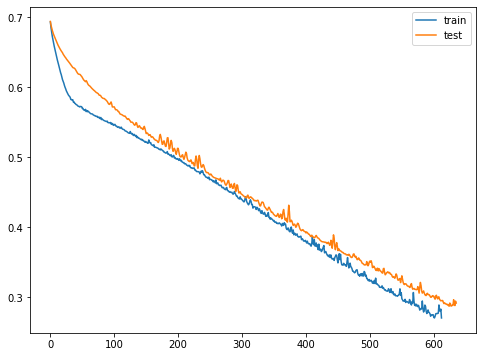

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(model.loss_curve_,label="train")
model_test = MLPClassifier(hidden_layer_sizes=[1024, 256, 64], learning_rate_init=0.0001, max_iter=10000)
model_test.fit(X_test, target_test)
plt.plot(model_test.loss_curve_,label="test")
plt.legend()

In the plot we reported the trend of the Loss curve with respect to the train dataset and the test dataset. Along the x axis I report the number of iterations performed while along the y axis I report the losses
In our case the two curves tend downwards as the iterations increase and consequently to an increasingly smaller value for the losses. This gradual reduction means that the model is learning during the training performed. The Test loss decreases at the same rate with respect to the train loss this means that the model generalizes very well. The loss curve, after about 600 iterations, reaches a loss value of about 0.3 for both the test and the train. The lower the loss value, the more this means that the model is learning.

## References

- Article from World Health Organization web-site: 
https://www.who.int/en/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)
- DataSet resources:
https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression